In [46]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# TensorFlow and Keras imports
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report

# Set the style for seaborn
sns.set_style('darkgrid')

# Extra settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [24]:
data_dir = r'C:\Users\MIjan\Desktop\ranbom\cap 2\dataset 1'

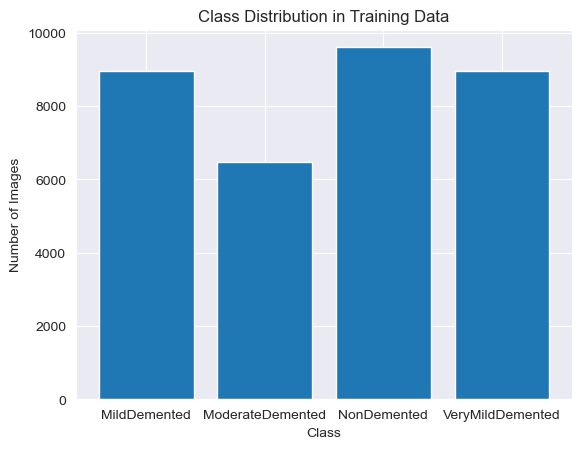

In [3]:
# Count images in each class
classes = ['MildDemented','ModerateDemented','NonDemented','VeryMildDemented']
class_counts = {cls: len(os.listdir(os.path.join(data_dir, cls))) for cls in classes}

# Plot class distribution
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Class Distribution in Training Data')
plt.show()

In [4]:
# Example using ImageDataGenerator to convert images to grayscale
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 27188 images belonging to 4 classes.
Found 6796 images belonging to 4 classes.


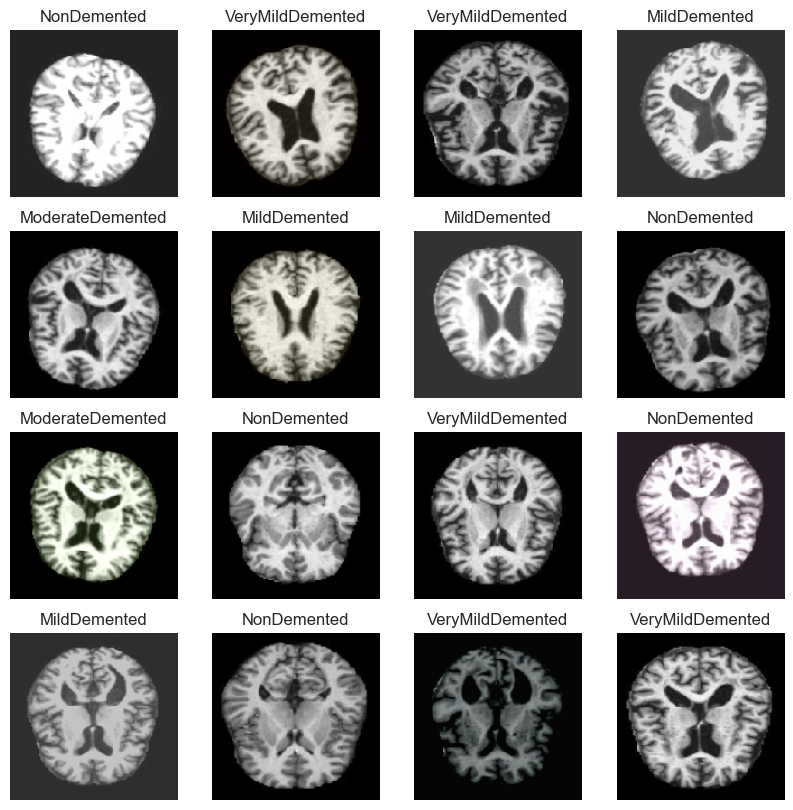

In [5]:
batch= next(train_generator)

fig,axes=plt.subplots(nrows=4,ncols=4,figsize=(10,10))

for i,ax in enumerate(axes.flat):
    ax.imshow(batch[0][i],cmap='gray')
    label_idx=batch[1][i].argmax()
    label_map ={v:k for k,v in train_generator.class_indices.items()}
    ax.set_title(label_map[label_idx])
    ax.axis('off')
plt.show()

In [10]:
model = Sequential()

# First convolutional block
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)))  # Adjust input shape if necessary
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Second convolutional block
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flattening the output of the convolutional blocks
model.add(Flatten())

# Fully connected layer with updated number of units
model.add(Dense(128, activation='relu'))  # Adjust the number of units if necessary
model.add(Dropout(0.5))

# Output layer
model.add(Dense(4, activation='softmax'))  # 4 output classes

model.summary()

checkpoint_callback = ModelCheckpoint(filepath='model.weights.h5',
                                       monitor='val_accuracy',
                                       save_best_only=True,
                                       save_weights_only=True,
                                       mode='max',
                                       verbose=1)

# Compiling the model
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

# Training the model
history = model.fit(
    train_generator,
    epochs=10,
    batch_size=64,
    validation_data=validation_generator,
    callbacks=[checkpoint_callback]
)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 148, 148, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 148, 148, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 74, 74, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 72, 72, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 72, 72, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 36, 36, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 41472)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │       5,308,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,314,340 (20.27 MB)

 Trainable params: 5,314,244 (20.27 MB)

 Non-trainable params: 96 (384.00 B)

Epoch 1/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.2814 - loss: 2.8605
Epoch 1: val_accuracy improved from -inf to 0.28252, saving model to model.weights.h5
850/850 ━━━━━━━━━━━━━━━━━━━━ 204s 238ms/step - accuracy: 0.2814 - loss: 2.8590 - val_accuracy: 0.2825 - val_loss: 1.3760
Epoch 2/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.2764 - loss: 1.3787
Epoch 2: val_accuracy did not improve from 0.28252
850/850 ━━━━━━━━━━━━━━━━━━━━ 200s 235ms/step - accuracy: 0.2764 - loss: 1.3787 - val_accuracy: 0.2825 - val_loss: 1.3757
Epoch 3/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.2823 - loss: 1.3756
Epoch 3: val_accuracy did not improve from 0.28252
850/850 ━━━━━━━━━━━━━━━━━━━━ 202s 237ms/step - accuracy: 0.2823 - loss: 1.3756 - val_accuracy: 0.2825 - val_loss: 1.3757
Epoch 4/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.2831 - loss: 1.3751
Epoch 4: val_accuracy did not improve from 0.28252
850/850 ━━━━━━━━━━━━━━━━━━━━ 203s 239ms/step -

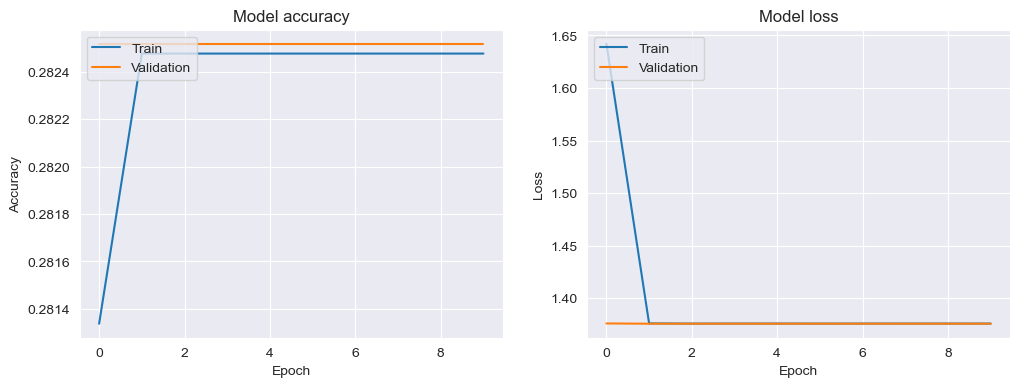

213/213 ━━━━━━━━━━━━━━━━━━━━ 11s 52ms/step


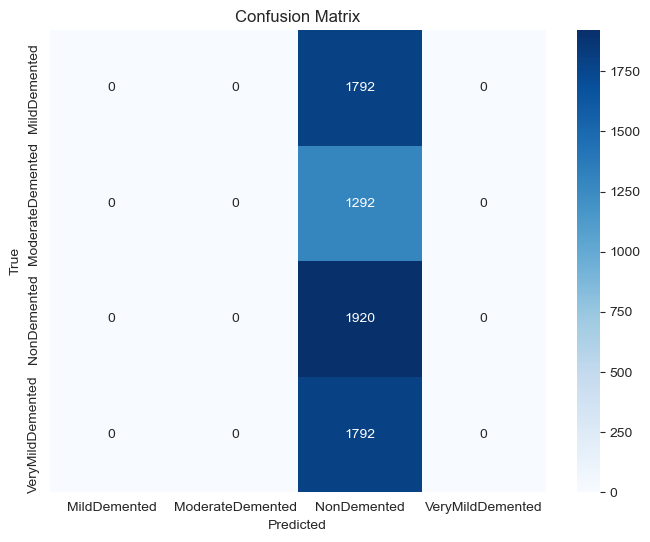

                  precision    recall  f1-score   support

    MildDemented       0.00      0.00      0.00      1792
ModerateDemented       0.00      0.00      0.00      1292
     NonDemented       0.28      1.00      0.44      1920
VeryMildDemented       0.00      0.00      0.00      1792

        accuracy                           0.28      6796
       macro avg       0.07      0.25      0.11      6796
    weighted avg       0.08      0.28      0.12      6796



In [14]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# Make predictions on the validation set
validation_generator.reset()
predictions = model.predict(validation_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Print classification report
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

In [19]:
model1 = Sequential()

# First convolutional block
model1.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(2, 2)))

# Second convolutional block
model1.add(Conv2D(64, (3, 3), activation='relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(2, 2)))

# Flattening the output of the convolutional blocks
model1.add(Flatten())

# Fully connected layer
model1.add(Dense(64, activation='relu'))
model1.add(Dropout(0.5))

# Output layer
model1.add(Dense(4, activation='softmax'))

model1.summary()

checkpoint_callback = ModelCheckpoint(filepath='model1.weights.h5',
                                       monitor='val_accuracy',
                                       save_best_only=True,
                                       save_weights_only=True,
                                       mode='max',
                                       verbose=1)

# Compiling the model
model1.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

# Training the model
history = model1.fit(
    train_generator,
    epochs=10,
    batch_size=64,
    validation_data=validation_generator,
    callbacks=[checkpoint_callback]
)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)                   │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 148, 148, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 72, 72, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 82944)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 64)                  │       5,308,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,328,516 (20.33 MB)

 Trainable params: 5,328,324 (20.33 MB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.2785 - loss: 2.5446
Epoch 1: val_accuracy improved from -inf to 0.28267, saving model to model1.weights.h5
850/850 ━━━━━━━━━━━━━━━━━━━━ 386s 452ms/step - accuracy: 0.2785 - loss: 2.5434 - val_accuracy: 0.2827 - val_loss: 1.3757
Epoch 2/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.2852 - loss: 1.3771
Epoch 2: val_accuracy did not improve from 0.28267
850/850 ━━━━━━━━━━━━━━━━━━━━ 384s 452ms/step - accuracy: 0.2852 - loss: 1.3771 - val_accuracy: 0.2827 - val_loss: 1.3756
Epoch 3/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - accuracy: 0.2833 - loss: 1.3748
Epoch 3: val_accuracy did not improve from 0.28267
850/850 ━━━━━━━━━━━━━━━━━━━━ 388s 457ms/step - accuracy: 0.2833 - loss: 1.3748 - val_accuracy: 0.2827 - val_loss: 1.3755
Epoch 4/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step - accuracy: 0.2801 - loss: 1.3769
Epoch 4: val_accuracy did not improve from 0.28267
850/850 ━━━━━━━━━━━━━━━━━━━━ 387s 455ms/step 

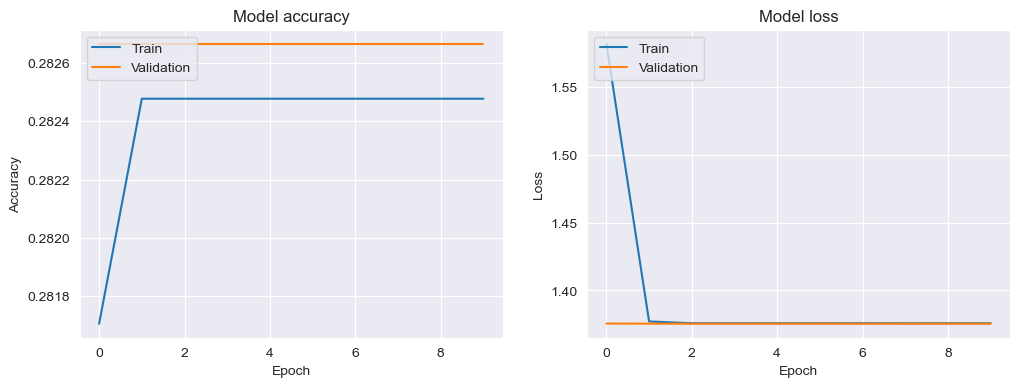

213/213 ━━━━━━━━━━━━━━━━━━━━ 11s 51ms/step


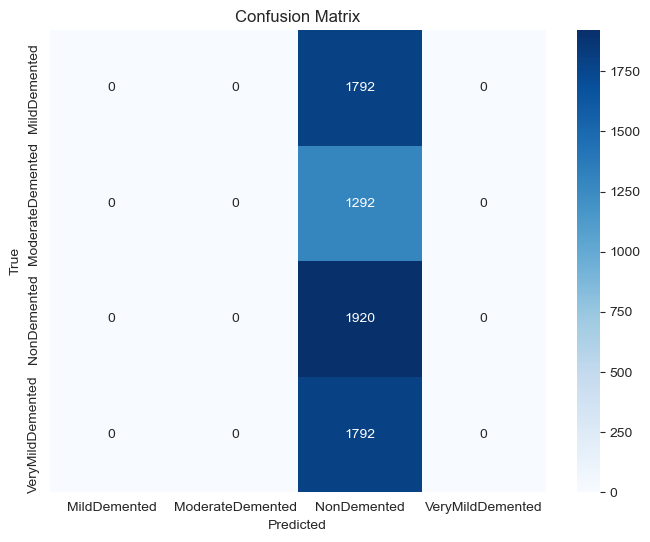

                  precision    recall  f1-score   support

    MildDemented       0.00      0.00      0.00      1792
ModerateDemented       0.00      0.00      0.00      1292
     NonDemented       0.28      1.00      0.44      1920
VeryMildDemented       0.00      0.00      0.00      1792

        accuracy                           0.28      6796
       macro avg       0.07      0.25      0.11      6796
    weighted avg       0.08      0.28      0.12      6796



In [20]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

213/213 ━━━━━━━━━━━━━━━━━━━━ 18s 85ms/step


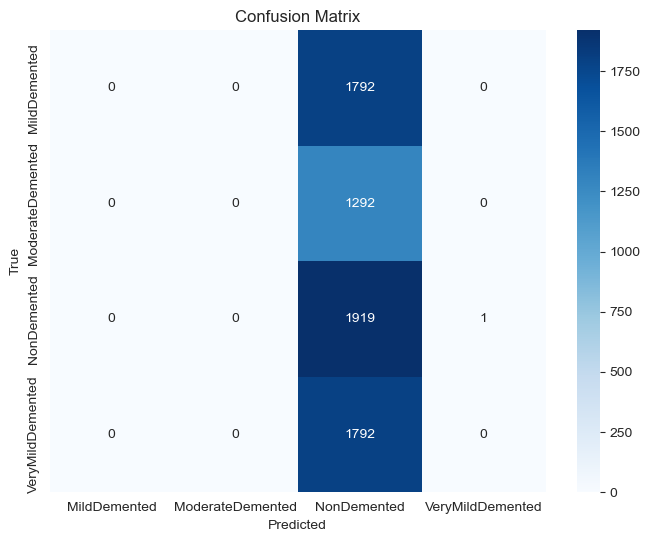

                  precision    recall  f1-score   support

    MildDemented       0.00      0.00      0.00      1792
ModerateDemented       0.00      0.00      0.00      1292
     NonDemented       0.28      1.00      0.44      1920
VeryMildDemented       0.00      0.00      0.00      1792

        accuracy                           0.28      6796
       macro avg       0.07      0.25      0.11      6796
    weighted avg       0.08      0.28      0.12      6796



In [47]:
# Make predictions on the validation set
validation_generator.reset()
predictions = model1.predict(validation_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Print classification report
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

In [21]:
model2 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')  # 4 classes: Mild Demented, Moderate Demented, NonDemented, Very Mild Demented
])


model2.summary()


checkpoint_callback = ModelCheckpoint(filepath='model2.weights.h5',
                                       monitor='val_accuracy',
                                       save_best_only=True,
                                       save_weights_only=True,
                                       mode='max',
                                       verbose=1)

# Compiling the model
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


# Training the model
history = model2.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=20 ,
    callbacks=[checkpoint_callback]
)

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)                   │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_9 (Flatten)                  │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 128)                 │       4,735,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,828,868 (18.42 MB)

 Trainable params: 4,828,868 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
849/849 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.4609 - loss: 1.1260
Epoch 1: val_accuracy improved from -inf to 0.67659, saving model to model2.weights.h5
849/849 ━━━━━━━━━━━━━━━━━━━━ 181s 212ms/step - accuracy: 0.4610 - loss: 1.1258 - val_accuracy: 0.6766 - val_loss: 0.6731
Epoch 2/20
  1/849 ━━━━━━━━━━━━━━━━━━━━ 2:39 188ms/step - accuracy: 0.5938 - loss: 0.7033
Epoch 2: val_accuracy did not improve from 0.67659
849/849 ━━━━━━━━━━━━━━━━━━━━ 0s 57us/step - accuracy: 0.5938 - loss: 0.7033 - val_accuracy: 0.5000 - val_loss: 0.7989
Epoch 3/20
849/849 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.6797 - loss: 0.6914
Epoch 3: val_accuracy improved from 0.67659 to 0.78803, saving model to model2.weights.h5
849/849 ━━━━━━━━━━━━━━━━━━━━ 180s 212ms/step - accuracy: 0.6797 - loss: 0.6914 - val_accuracy: 0.7880 - val_loss: 0.4738
Epoch 4/20
  1/849 ━━━━━━━━━━━━━━━━━━━━ 2:42 192ms/step - accuracy: 0.6875 - loss: 0.5036
Epoch 4: val_accuracy did not improve from 0.78803
849/8

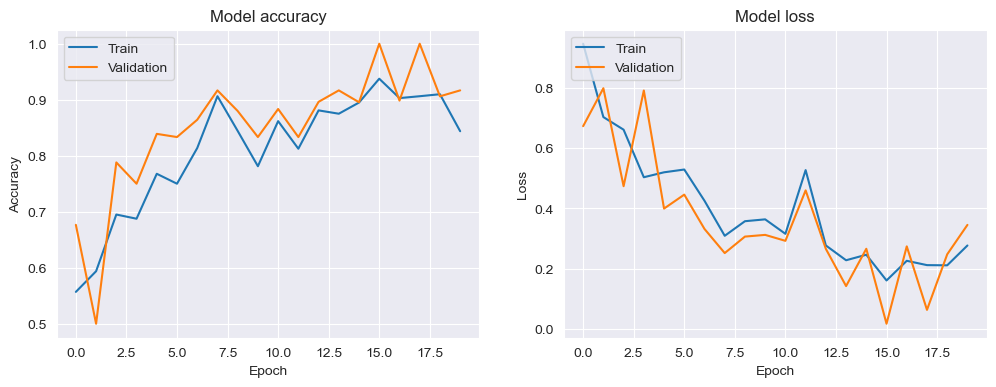

213/213 ━━━━━━━━━━━━━━━━━━━━ 14s 64ms/step


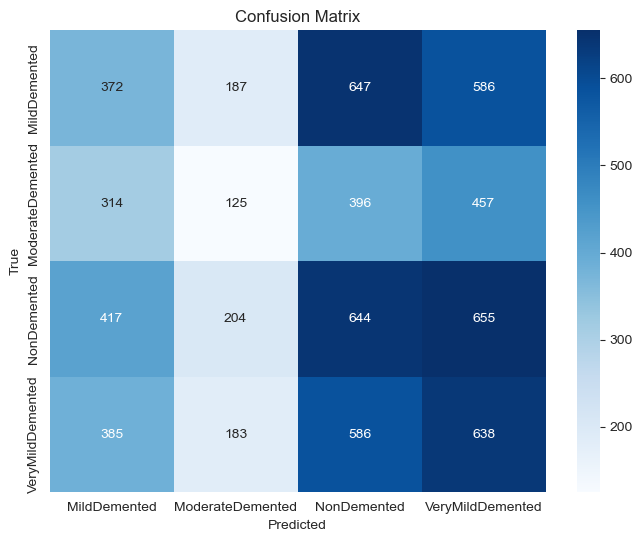

                  precision    recall  f1-score   support

    MildDemented       0.25      0.21      0.23      1792
ModerateDemented       0.18      0.10      0.13      1292
     NonDemented       0.28      0.34      0.31      1920
VeryMildDemented       0.27      0.36      0.31      1792

        accuracy                           0.26      6796
       macro avg       0.25      0.25      0.24      6796
    weighted avg       0.25      0.26      0.25      6796



In [33]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# Make predictions on the validation set
validation_generator.reset()
predictions = model2.predict(validation_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Print classification report
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

In [32]:
# Data augmentation and rescaling for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Set validation split ratio
)

# Rescaling for validation data
validation_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  
)

# Training data generator
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='training'  
)

# Validation data generator
validation_generator = validation_datagen.flow_from_directory(
    data_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation'  # Use the validation subset
)


Found 27188 images belonging to 4 classes.
Found 6796 images belonging to 4 classes.


In [34]:
model3 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')  # 4 classes: Mild Demented, Moderate Demented, NonDemented, Very Mild Demented
])


model3.summary()


checkpoint_callback = ModelCheckpoint(filepath='model3.weights.h5',
                                       monitor='val_accuracy',
                                       save_best_only=True,
                                       save_weights_only=True,
                                       mode='max',
                                       verbose=1)

# Compiling the model
model3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


# Training the model
history = model3.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=20 ,
    callbacks=[checkpoint_callback]
)

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)                   │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_24 (MaxPooling2D)      │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_25 (MaxPooling2D)      │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_26 (MaxPooling2D)      │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_11 (Flatten)                 │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 128)                 │       4,735,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,828,868 (18.42 MB)

 Trainable params: 4,828,868 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
849/849 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - accuracy: 0.3060 - loss: 1.3713
Epoch 1: val_accuracy improved from -inf to 0.41215, saving model to model3.weights.h5
849/849 ━━━━━━━━━━━━━━━━━━━━ 281s 329ms/step - accuracy: 0.3061 - loss: 1.3712 - val_accuracy: 0.4121 - val_loss: 1.2150
Epoch 2/20
  1/849 ━━━━━━━━━━━━━━━━━━━━ 3:26 244ms/step - accuracy: 0.4062 - loss: 1.2459
Epoch 2: val_accuracy did not improve from 0.41215
849/849 ━━━━━━━━━━━━━━━━━━━━ 0s 59us/step - accuracy: 0.4062 - loss: 1.2459 - val_accuracy: 0.3333 - val_loss: 1.3180
Epoch 3/20
849/849 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - accuracy: 0.3914 - loss: 1.2479
Epoch 3: val_accuracy improved from 0.41215 to 0.45504, saving model to model3.weights.h5
849/849 ━━━━━━━━━━━━━━━━━━━━ 274s 321ms/step - accuracy: 0.3914 - loss: 1.2478 - val_accuracy: 0.4550 - val_loss: 1.1169
Epoch 4/20
  1/849 ━━━━━━━━━━━━━━━━━━━━ 3:01 214ms/step - accuracy: 0.3438 - loss: 1.2659
Epoch 4: val_accuracy improved from 0.45504 to 0.58333, 

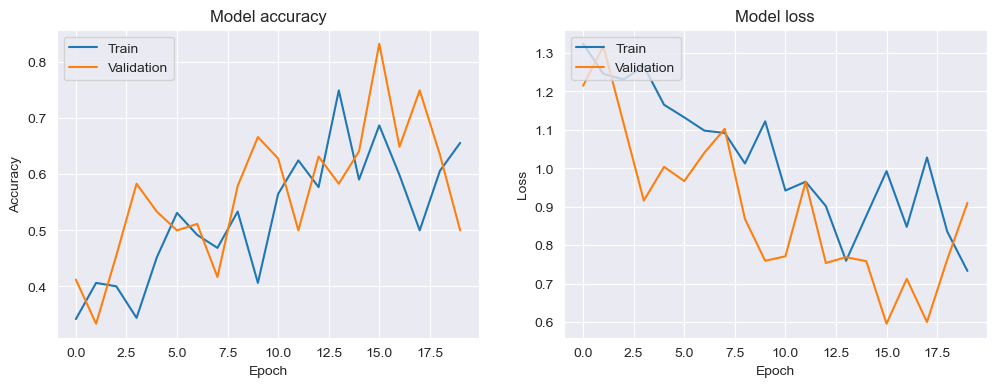

213/213 ━━━━━━━━━━━━━━━━━━━━ 14s 64ms/step


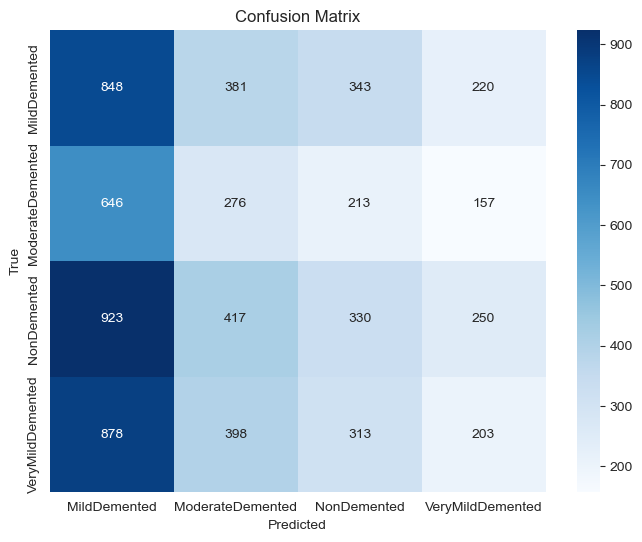

                  precision    recall  f1-score   support

    MildDemented       0.26      0.47      0.33      1792
ModerateDemented       0.19      0.21      0.20      1292
     NonDemented       0.28      0.17      0.21      1920
VeryMildDemented       0.24      0.11      0.15      1792

        accuracy                           0.24      6796
       macro avg       0.24      0.24      0.22      6796
    weighted avg       0.25      0.24      0.23      6796



In [36]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# Make predictions on the validation set
validation_generator.reset()
predictions = model3.predict(validation_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Print classification report
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

In [37]:
model4 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')  # 4 classes: Mild Demented, Moderate Demented, NonDemented, Very Mild Demented
])


model4.summary()


checkpoint_callback = ModelCheckpoint(filepath='model4.weights.h5',
                                       monitor='val_accuracy',
                                       save_best_only=True,
                                       save_weights_only=True,
                                       mode='max',
                                       verbose=1)

# Compiling the model
model4.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])


# Training the model
history = model4.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=20 ,
    callbacks=[checkpoint_callback]
)

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_27 (Conv2D)                   │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_27 (MaxPooling2D)      │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_28 (Conv2D)                   │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_28 (MaxPooling2D)      │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_29 (MaxPooling2D)      │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_12 (Flatten)                 │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 128)                 │       4,735,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,828,868 (18.42 MB)

 Trainable params: 4,828,868 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
849/849 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - accuracy: 0.3171 - loss: 1.3757
Epoch 1: val_accuracy improved from -inf to 0.43868, saving model to model4.weights.h5
849/849 ━━━━━━━━━━━━━━━━━━━━ 287s 336ms/step - accuracy: 0.3172 - loss: 1.3756 - val_accuracy: 0.4387 - val_loss: 1.1879
Epoch 2/20
  1/849 ━━━━━━━━━━━━━━━━━━━━ 2:48 199ms/step - accuracy: 0.4688 - loss: 1.1982
Epoch 2: val_accuracy improved from 0.43868 to 0.58333, saving model to model4.weights.h5
849/849 ━━━━━━━━━━━━━━━━━━━━ 0s 107us/step - accuracy: 0.4688 - loss: 1.1982 - val_accuracy: 0.5833 - val_loss: 1.1066
Epoch 3/20
849/849 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - accuracy: 0.4243 - loss: 1.2065
Epoch 3: val_accuracy did not improve from 0.58333
849/849 ━━━━━━━━━━━━━━━━━━━━ 327s 384ms/step - accuracy: 0.4243 - loss: 1.2065 - val_accuracy: 0.5675 - val_loss: 0.9446
Epoch 4/20
  1/849 ━━━━━━━━━━━━━━━━━━━━ 2:47 198ms/step - accuracy: 0.5938 - loss: 0.9929
Epoch 4: val_accuracy improved from 0.58333 to 0.75000,

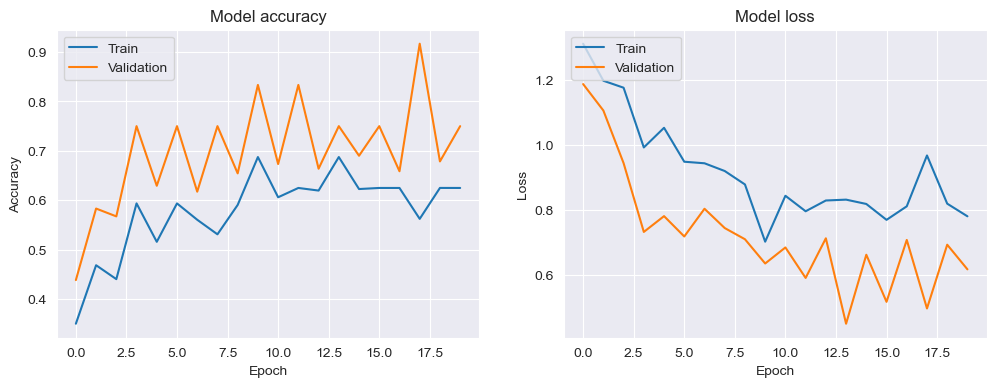

213/213 ━━━━━━━━━━━━━━━━━━━━ 14s 65ms/step


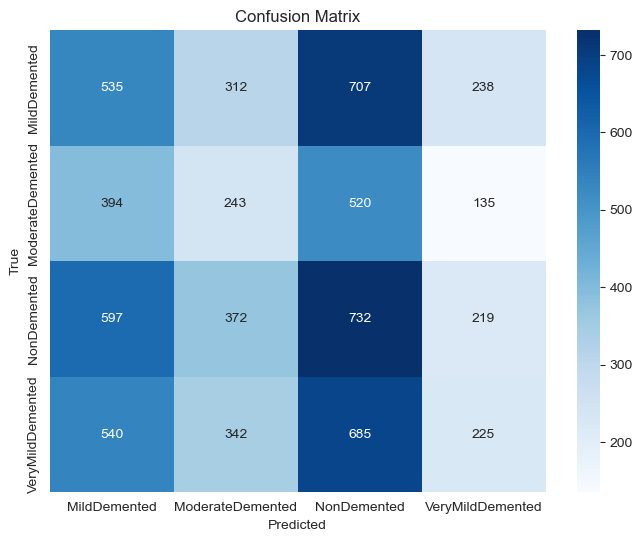

                  precision    recall  f1-score   support

    MildDemented       0.26      0.30      0.28      1792
ModerateDemented       0.19      0.19      0.19      1292
     NonDemented       0.28      0.38      0.32      1920
VeryMildDemented       0.28      0.13      0.17      1792

        accuracy                           0.26      6796
       macro avg       0.25      0.25      0.24      6796
    weighted avg       0.26      0.26      0.25      6796



In [39]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# Make predictions on the validation set
validation_generator.reset()
predictions = model4.predict(validation_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Print classification report
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

In [40]:
# Building the model
model5 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')  # 4 classes: Mild Demented, Moderate Demented, NonDemented, Very Mild Demented
])

model5.summary()

# Callbacks
checkpoint_callback = ModelCheckpoint(
    filepath='model5.weights.h5',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=True,
    mode='max',
    verbose=1
)

reduce_lr_callback = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
    mode='auto',
    min_lr=1e-6
)

# Compiling the model
model5.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Training the model
history = model5.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=30,
    callbacks=[checkpoint_callback, reduce_lr_callback]
)


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_30 (Conv2D)                   │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 148, 148, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_30 (MaxPooling2D)      │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_31 (Conv2D)                   │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 72, 72, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_31 (MaxPooling2D)      │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_32 (Conv2D)                   │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 34, 34, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_32 (MaxPooling2D)      │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_33 (Conv2D)                   │ (None, 15, 15, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_21               │ (None, 15, 15, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_33 (MaxPooling2D)      │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_13 (Flatten)                 │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 256)                 │       3,211,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,602,884 (13.74 MB)

 Trainable params: 3,601,924 (13.74 MB)

 Non-trainable params: 960 (3.75 KB)

Epoch 1/30
849/849 ━━━━━━━━━━━━━━━━━━━━ 0s 603ms/step - accuracy: 0.3349 - loss: 1.5308
Epoch 1: val_accuracy improved from -inf to 0.43544, saving model to model5.weights.h5
849/849 ━━━━━━━━━━━━━━━━━━━━ 537s 628ms/step - accuracy: 0.3349 - loss: 1.5306 - val_accuracy: 0.4354 - val_loss: 1.1872 - learning_rate: 1.0000e-04
Epoch 2/30
  1/849 ━━━━━━━━━━━━━━━━━━━━ 7:48 553ms/step - accuracy: 0.5000 - loss: 1.2851
Epoch 2: val_accuracy improved from 0.43544 to 0.83333, saving model to model5.weights.h5
849/849 ━━━━━━━━━━━━━━━━━━━━ 1s 173us/step - accuracy: 0.5000 - loss: 1.2851 - val_accuracy: 0.8333 - val_loss: 0.8321 - learning_rate: 1.0000e-04
Epoch 3/30
849/849 ━━━━━━━━━━━━━━━━━━━━ 0s 606ms/step - accuracy: 0.3960 - loss: 1.2423
Epoch 3: val_accuracy did not improve from 0.83333
849/849 ━━━━━━━━━━━━━━━━━━━━ 538s 633ms/step - accuracy: 0.3960 - loss: 1.2423 - val_accuracy: 0.3955 - val_loss: 1.1956 - learning_rate: 1.0000e-04
Epoch 4/30
  1/849 ━━━━━━━━━━━━━━━━━━━━ 7:33 535ms/step - acc

Epoch 23/30
849/849 ━━━━━━━━━━━━━━━━━━━━ 0s 572ms/step - accuracy: 0.6069 - loss: 0.8433
Epoch 23: val_accuracy did not improve from 0.83333
849/849 ━━━━━━━━━━━━━━━━━━━━ 507s 596ms/step - accuracy: 0.6069 - loss: 0.8433 - val_accuracy: 0.6495 - val_loss: 0.7558 - learning_rate: 3.1250e-06
Epoch 24/30
  1/849 ━━━━━━━━━━━━━━━━━━━━ 7:15 513ms/step - accuracy: 0.7500 - loss: 0.6733
Epoch 24: val_accuracy did not improve from 0.83333
849/849 ━━━━━━━━━━━━━━━━━━━━ 1s 68us/step - accuracy: 0.7500 - loss: 0.6733 - val_accuracy: 0.6667 - val_loss: 0.7374 - learning_rate: 3.1250e-06
Epoch 25/30
849/849 ━━━━━━━━━━━━━━━━━━━━ 0s 581ms/step - accuracy: 0.6106 - loss: 0.8375
Epoch 25: val_accuracy did not improve from 0.83333

Epoch 25: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.
849/849 ━━━━━━━━━━━━━━━━━━━━ 515s 605ms/step - accuracy: 0.6106 - loss: 0.8375 - val_accuracy: 0.6654 - val_loss: 0.7284 - learning_rate: 3.1250e-06
Epoch 26/30
  1/849 ━━━━━━━━━━━━━━━━━━━━ 7:35 538ms/st

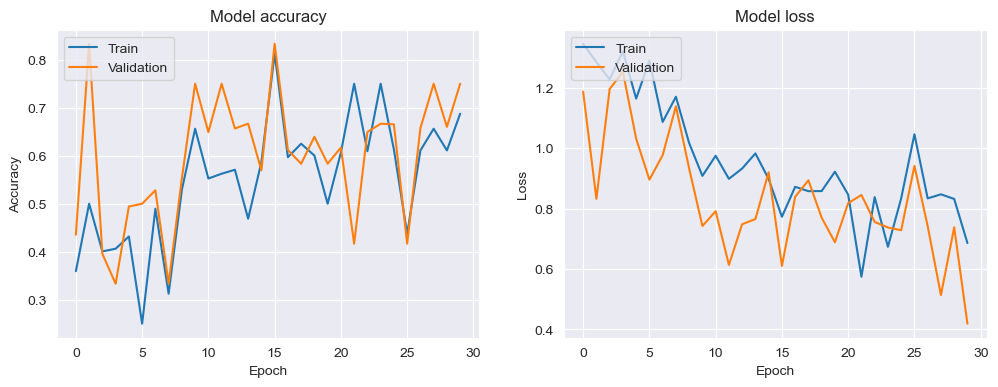

213/213 ━━━━━━━━━━━━━━━━━━━━ 13s 62ms/step


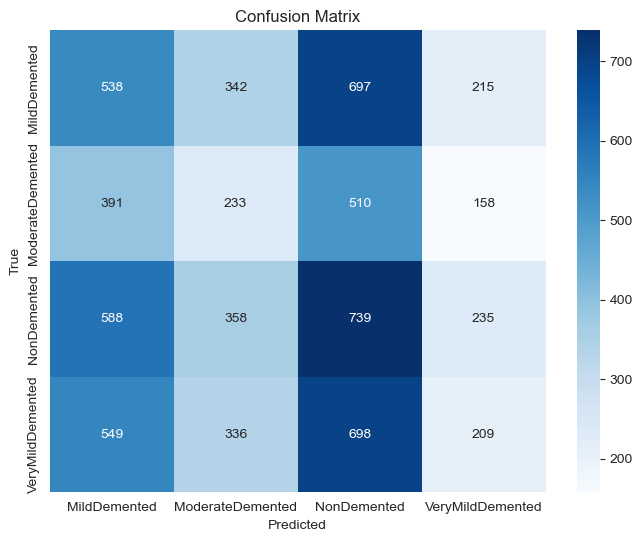

                  precision    recall  f1-score   support

    MildDemented       0.26      0.30      0.28      1792
ModerateDemented       0.18      0.18      0.18      1292
     NonDemented       0.28      0.38      0.32      1920
VeryMildDemented       0.26      0.12      0.16      1792

        accuracy                           0.25      6796
       macro avg       0.24      0.25      0.24      6796
    weighted avg       0.25      0.25      0.24      6796



In [41]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# Make predictions on the validation set
validation_generator.reset()
predictions = model5.predict(validation_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Print classification report
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

In [44]:
# Calculating class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

# Building the model using VGG16
base_model = VGG16(include_top=False, input_shape=(150, 150, 3))

model6 = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')  # 4 classes: Mild Demented, Moderate Demented, NonDemented, Very Mild Demented
])

# Freeze the layers of VGG16
for layer in base_model.layers:
    layer.trainable = False

model6.summary()

# Callbacks
checkpoint_callback = ModelCheckpoint(
    filepath='model6.weights.h5',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=True,
    mode='max',
    verbose=1
)

reduce_lr_callback = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
    mode='auto',
    min_lr=1e-6
)

# Compiling the model
model6.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Training the model
history = model6.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=30,
    class_weight=class_weights,
    callbacks=[checkpoint_callback, reduce_lr_callback]
)

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ ?                           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_14 (Flatten)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/30
849/849 ━━━━━━━━━━━━━━━━━━━━ 0s 838ms/step - accuracy: 0.3779 - loss: 1.3247
Epoch 1: val_accuracy improved from -inf to 0.60967, saving model to model6.weights.h5
849/849 ━━━━━━━━━━━━━━━━━━━━ 889s 1s/step - accuracy: 0.3780 - loss: 1.3246 - val_accuracy: 0.6097 - val_loss: 0.9403 - learning_rate: 1.0000e-04
Epoch 2/30
  1/849 ━━━━━━━━━━━━━━━━━━━━ 11:09 789ms/step - accuracy: 0.3438 - loss: 1.0862
Epoch 2: val_accuracy improved from 0.60967 to 0.66667, saving model to model6.weights.h5
849/849 ━━━━━━━━━━━━━━━━━━━━ 1s 535us/step - accuracy: 0.3438 - loss: 1.0862 - val_accuracy: 0.6667 - val_loss: 0.9258 - learning_rate: 1.0000e-04
Epoch 3/30
849/849 ━━━━━━━━━━━━━━━━━━━━ 0s 866ms/step - accuracy: 0.5266 - loss: 1.0504
Epoch 3: val_accuracy did not improve from 0.66667
849/849 ━━━━━━━━━━━━━━━━━━━━ 911s 1s/step - accuracy: 0.5266 - loss: 1.0504 - val_accuracy: 0.6201 - val_loss: 0.8429 - learning_rate: 1.0000e-04
Epoch 4/30
  1/849 ━━━━━━━━━━━━━━━━━━━━ 14:03 995ms/step - accurac

Epoch 23/30
849/849 ━━━━━━━━━━━━━━━━━━━━ 0s 881ms/step - accuracy: 0.6383 - loss: 0.7719
Epoch 23: val_accuracy did not improve from 0.83333

Epoch 23: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.
849/849 ━━━━━━━━━━━━━━━━━━━━ 926s 1s/step - accuracy: 0.6383 - loss: 0.7719 - val_accuracy: 0.6952 - val_loss: 0.6829 - learning_rate: 6.2500e-06
Epoch 24/30
  1/849 ━━━━━━━━━━━━━━━━━━━━ 11:38 824ms/step - accuracy: 0.5312 - loss: 0.7841
Epoch 24: val_accuracy did not improve from 0.83333
849/849 ━━━━━━━━━━━━━━━━━━━━ 1s 424us/step - accuracy: 0.5312 - loss: 0.7841 - val_accuracy: 0.6667 - val_loss: 0.5473 - learning_rate: 3.1250e-06
Epoch 25/30
849/849 ━━━━━━━━━━━━━━━━━━━━ 0s 877ms/step - accuracy: 0.6480 - loss: 0.7645
Epoch 25: val_accuracy did not improve from 0.83333
849/849 ━━━━━━━━━━━━━━━━━━━━ 924s 1s/step - accuracy: 0.6480 - loss: 0.7645 - val_accuracy: 0.6949 - val_loss: 0.6825 - learning_rate: 3.1250e-06
Epoch 26/30
  1/849 ━━━━━━━━━━━━━━━━━━━━ 12:13 865ms/step 

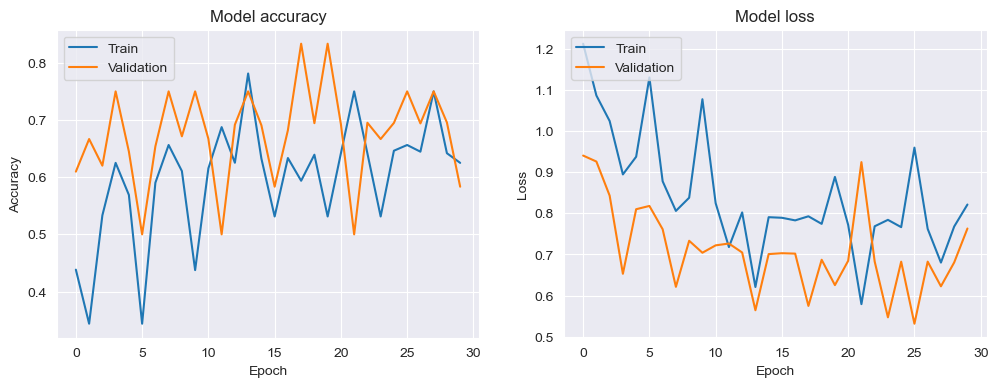

213/213 ━━━━━━━━━━━━━━━━━━━━ 171s 803ms/step


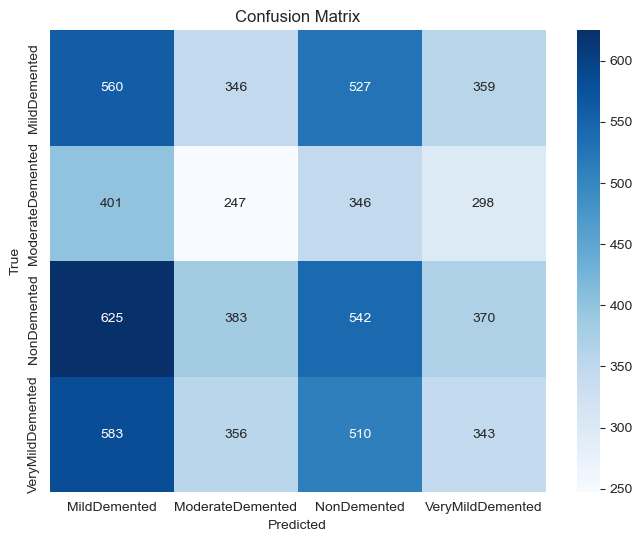

                  precision    recall  f1-score   support

    MildDemented       0.26      0.31      0.28      1792
ModerateDemented       0.19      0.19      0.19      1292
     NonDemented       0.28      0.28      0.28      1920
VeryMildDemented       0.25      0.19      0.22      1792

        accuracy                           0.25      6796
       macro avg       0.24      0.24      0.24      6796
    weighted avg       0.25      0.25      0.25      6796



In [45]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# Make predictions on the validation set
validation_generator.reset()
predictions = model6.predict(validation_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Print classification report
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

In [59]:
model6.save('model6.h5')

In [2]:
# Load your trained model
model = tf.keras.models.load_model('model6.h5')

In [3]:
import numpy as np
import tensorflow as tf
import gradio as gr


# Define class names based on your model's output
class_names = ['Mild Demented', 'Moderate Demented', 'NonDemented', 'Very Mild Demented']

# Define the image preprocessing function
def preprocess_image(img):
    # Add your preprocessing steps here
    # For example, resizing and normalization:
    img = tf.image.resize(img, [150, 150])  # Resize to the input size of your model
    img = img / 255.0  # Normalize to [0, 1]
    return img

# Define the prediction function
def predict_image(img):
    img = preprocess_image(img)  # Preprocess image
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    predictions = model.predict(img)
    return {class_names[i]: float(pred) for i, pred in enumerate(predictions[0])}

# Set up the Gradio interface
interface = gr.Interface(
    fn=predict_image,
    inputs=gr.Image(type='numpy', image_mode='RGB'),  # Specify input type and image mode
    outputs=gr.Label(num_top_classes=len(class_names)),
    title="Dementia Classification",
    description="Upload an image to classify it into one of the dementia categories."
)

# Launch the Gradio app
interface.launch()


Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


In [ ]:
import gradio as gr
import numpy as np
from keras.preprocessing.image import img_to_array, load_img
from keras.models import load_model

# Load your trained model (assuming it's saved as 'best_model.h5')
model = load_model('model2.h5')

# Define a function for preprocessing the input and making a prediction
def predict(image):
    # Resize the image to match the input size of the model and convert it to grayscale
    img = load_img(image, target_size=(128, 128), color_mode='grayscale')
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)  # Expand dimensions to match the input shape of (1, 128, 128, 1)
    img = img / 255.0  # Normalize the image

    # Make a prediction
    prediction = model.predict(img)
    class_labels = ['Mild Demented', 'Moderate Demented', 'NonDemented', 'Very Mild Demented']
    prediction = {label: float(prob) for label, prob in zip(class_labels, prediction[0])}
    return prediction

# Create a Gradio interface
interface = gr.Interface(fn=predict_image, inputs=image, outputs=label)

# Launch the app
interface.launch()


In [ ]:
import gradio as gr

# Define the input and output for the Gradio interface
image = gr.Image()
label = gr.Label(num_top_classes=4)

# Create the Gradio interface
interface = gr.Interface(fn=predict_image, inputs=image, outputs=label)

# Launch the Gradio interface
interface.launch(share=True)
